In [1]:
import sys
sys.path.append('../')

In [2]:
# import self-written modules
from FeatEngg import ngramEnc,ctdEnc,gaacEnc
from mySVM.model import SVM
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# import self-written modules
from IndModels.models import PosModel,NGModel,GAACModel
from Ensemble.model import Ensemble

In [4]:
# import modules
import numpy as np

np.random.seed(7)

In [5]:
file = pickle.load(open('../Data/TE_ML_Data_pickle.p','rb'))

In [6]:
from helper import parseEnzymeFile,modified_split

In [7]:
enzyme_filename = '../Data/Enzyme_Dataset.txt'

X,y,enz_names = parseEnzymeFile(enzyme_filename)

In [8]:
test_idx,train_idx = modified_split(enz_names)

In [9]:
Xtrain_raw,ytrain,Xtest_raw,ytest = X[train_idx],y[train_idx],X[test_idx],y[test_idx]

In [10]:
ngram = ngramEnc.Ngram(Xtrain_raw,3,1)

In [11]:
ngram.fit()

In [12]:
X_enc  = ngram.transform(Xtrain_raw)

In [13]:
np.unique(X_enc[0])

array([0., 1., 2.])

# Position-Model

In [14]:
from IndModels.models import PosModel

In [16]:
posModel = PosModel('../Data/TE_ML_Data_pickle.p',enz_names,X,y,train_idx,test_idx)

In [20]:
posModel.SVMobject.acc_test,posModel.SVMobject.acc_train

(0.76, 0.9629629629629629)

# NG only model

In [36]:
ngram = ngramEnc.Ngram(Xtrain_raw,3,1)

ngram.fit()

Xtrain_ng,ytrain_ng,Xtest_ng,ytest_ng = ngram.transform(Xtrain_raw),y[train_idx],ngram.transform(Xtest_raw),y[test_idx]

In [24]:
ng_k = [3,5,7,9,11,13]
ng_steps = [1,3,5,9,11]

ng_accs = []
ng_idx = []

for ki in ng_k:
    for si in ng_steps:
        
        if si>ki:
            break
        else:
            ng_idx.append(f'{str(si)},{str(ki)}')
            ngModel_idx = NGModel(enz_names,X,y,train_idx,test_idx,k=ki,s=si,verboseQ=False)
            ng_accs.append((ngModel_idx.SVMobject.acc_train,ngModel_idx.SVMobject.acc_test))

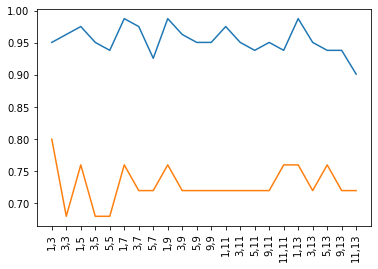

In [25]:
plt.plot(ng_accs)
plt.xticks(list(range(len(ng_idx))),ng_idx,rotation=90);

In [26]:
from IndModels.models import NGModel

ngModel = NGModel(enz_names,X,y,train_idx,test_idx,k=3,s=1,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9506172839506173-----
-----Testing Accuracy:0.8-----


# GAAC and NG model

In [27]:
gc = gaacEnc.GAAC()

X_gaac = gc.transform(X)

Xtrain_raw_gaac,ytrain_gaac,Xtest_raw_gaac,ytest_gaac = X_gaac[train_idx],y[train_idx],X_gaac[test_idx],y[test_idx]

ng_gaac = ngramEnc.Ngram(Xtrain_raw_gaac,9,1)

ng_gaac.fit()

Xtrain_gaac,Xtest_gaac = ng_gaac.transform(Xtrain_raw_gaac),ng_gaac.transform(Xtest_raw_gaac)

In [28]:
model_gaac = SVM(Xtrain_gaac,Xtest_gaac,ytrain,ytest,pca_comp=40,regC=20,kern='rbf',optimize=False)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9629629629629629-----
-----Testing Accuracy:0.76-----


In [29]:
gaac_k = [3,5,7,9,11,13]
gaac_steps = [1,3,5,9,11]

gaac_accs = []
gaac_idx = []

for k in gaac_k:
    for s in gaac_steps:
        
        if s>k:
            break
        else:
            gaac_idx.append(f'{str(s)},{str(k)}')
            gaac_isk = ngramEnc.Ngram(Xtrain_raw_gaac,k,s)
            gaac_isk.fit()
            Xtrain_gaac_isk,Xtest_gaac_isk = gaac_isk.transform(Xtrain_raw_gaac),gaac_isk.transform(Xtest_raw_gaac)
            model_gaac_isk = SVM(Xtrain_gaac_isk,Xtest_gaac_isk,ytrain,ytest,pca_comp=20,regC=100,kern='rbf',optimize=False,verbose=False)
            gaac_accs.append((model_gaac_isk.acc_train,model_gaac_isk.acc_test))

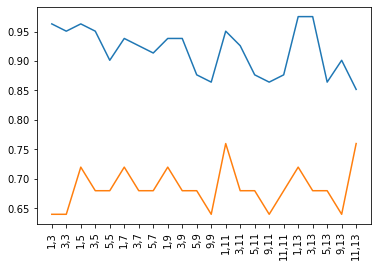

In [30]:
plt.plot(gaac_accs)
plt.xticks(list(range(len(gaac_idx))),gaac_idx,rotation=90);

# CTD model

In [31]:
cc = ctdEnc.CTD(F='C')

X_ctd = cc.get_ctd(X)

Xtrain_ctd,ytrain_ctd,Xtest_ctd,ytest_ctd = X_ctd[train_idx],y[train_idx],X_ctd[test_idx],y[test_idx]

In [32]:
model_ctd = SVM(Xtrain_ctd,Xtest_ctd,ytrain,ytest,optimize=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.691358024691358-----
-----Testing Accuracy:0.68-----
-----Hyperparameter Optimization-----
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1854s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1071s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0959s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1262s.) Setting batch_size=16.


score = 0.56
{'SVM__C': 100, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'pca__n_components': 5}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.9s finished


# Majority Vote Classifier

In [33]:
from Ensemble.model import Ensemble

In [39]:
EModel = Ensemble([ngModel.model,model_gaac.model,posModel.model],
                  [Xtest_ng,Xtest_gaac,posModel.Xtest],ytest)

In [40]:
ytest

array([1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 2, 1, 1,
       3, 1, 2])

In [41]:
np.where(EModel.preds != ytest)

(array([ 3,  4, 19, 21, 22, 24]),)

In [42]:
EModel.preds!=ytest

array([False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True])

In [43]:
enz_names[test_idx][np.where(EModel.preds != ytest)[0]]

array(['Ulmus_americana', 'Cuphea_viscosisssima_(CvFatB2', 'rTE44',
       'Cuphea_viscosisssima_(CvB2MT29',
       'Umbellularia_californica_(UcFatB2)',
       'Cuphea_viscosisssima_(CvB2MT2'], dtype='<U34')

In [44]:
EModel.acc

0.76

# Different random seeds

In [57]:
accs = []
for i in range(1000):
    np.random.seed(i)
    test_idx_i,train_idx_i = modified_split(enz_names)
    Xtrain_raw_i,ytrain_i,Xtest_raw_i,ytest_i = X[train_idx_i],y[train_idx_i],X[test_idx_i],y[test_idx_i]
    
    ng_i = ngramEnc.Ngram(Xtrain_raw_i,7,1)
    ng_i.fit()
    Xtrain_ng_i,Xtest_ng_i = ng_i.transform(Xtrain_raw_i),ng_i.transform(Xtest_raw_i)
    model_ng_i = SVM(Xtrain_ng_i,Xtest_ng_i,ytrain_i,ytest_i,pca_comp=40,regC=1,kern='linear',optimize=False,verbose=False)
    
    gc_i = gaacEnc.GAAC()
    X_gaac_i = gc_i.transform(X)
    Xtrain_raw_gaac_i,Xtest_raw_gaac_i = X_gaac_i[train_idx_i],X_gaac_i[test_idx_i]
    ng_gaac_i = ngramEnc.Ngram(Xtrain_raw_gaac_i,13,1)
    ng_gaac_i.fit()
    Xtrain_gaac_i,Xtest_gaac_i = ng_gaac_i.transform(Xtrain_raw_gaac_i),ng_gaac_i.transform(Xtest_raw_gaac_i)
    model_gaac_i = SVM(Xtrain_gaac_i,Xtest_gaac_i,ytrain_i,ytest_i,pca_comp=40,regC=100,kern='rbf',optimize=False,verbose=False)
    
#     cc_i = ctdEnc.CTD(F='C')
#     X_ctd_i = cc_i.get_ctd(X)
#     Xtrain_ctd_i,Xtest_ctd_i = X_ctd_i[train_idx_i],X_ctd_i[test_idx_i]
#     model_ctd_i = SVM(Xtrain_ctd_i,Xtest_ctd_i,ytrain_i,ytest_i,pca_comp=20,regC=100,kern='rbf',optimize=False,verbose=False)
    Xtrain_pos_i,Xtest_pos_i = get_pos_model_feat(Pos_model_dict,enz_names,train_idx_i,test_idx_i)
    model_pos_i = SVM(Xtrain_pos_i,Xtest_pos_i,ytrain_i,ytest_i,pca_comp=40,regC=1,kern='linear',optimize=False,verbose=False)
    
    EModel_i = Ensemble([model_ng_i.model,model_gaac_i.model,model_pos_i.model],
                  [Xtest_ng_i,Xtest_gaac_i,Xtest_pos_i],ytest_i)
    
    accs.append((model_ng_i.acc_test,model_gaac_i.acc_test,model_pos_i.acc_test,EModel_i.acc))
    
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


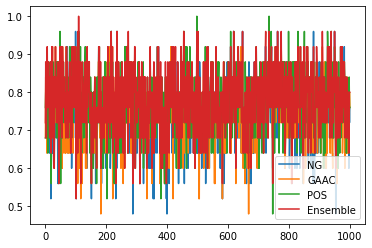

In [58]:
plt.plot(range(len(accs)),accs)
plt.legend(['NG','GAAC','POS','Ensemble'])

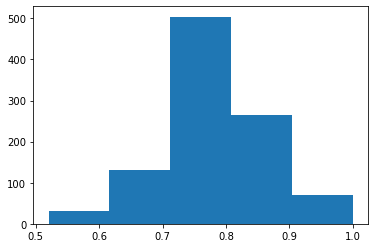

In [59]:
Ensemble_preds = [a[3] for a in accs]
plt.hist(Ensemble_preds,bins=5);

In [60]:
min(Ensemble_preds)

0.52

In [61]:
np.mean(Ensemble_preds)

0.78028

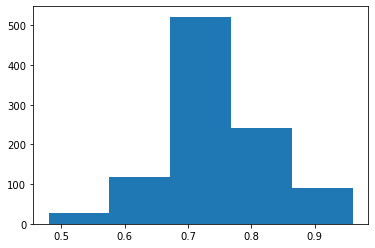

In [62]:
Gaac_preds = [a[1] for a in accs]
plt.hist(Gaac_preds,bins=5);

In [63]:
sum([1 for g in Gaac_preds if g<0.6 ])

28

In [64]:
min(Gaac_preds)

0.48

In [65]:
np.mean(Gaac_preds)

0.7458400000000001

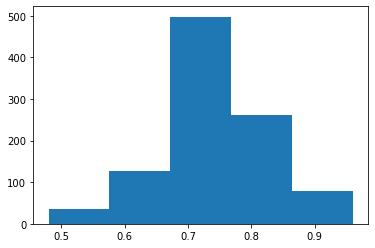

In [66]:
ng_preds = [a[0] for a in accs]
plt.hist(ng_preds,bins=5);

In [67]:
np.mean(ng_preds)

0.7421599999999999

In [68]:
min(ng_preds)

0.48

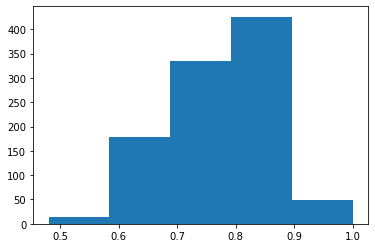

In [69]:
ctd_preds = [a[2] for a in accs]
plt.hist(ctd_preds,bins=5);

In [70]:
min(ctd_preds)

0.48

In [71]:
np.mean(ctd_preds)

0.77176